# Erythroid

Comparison with deep learning RNA velocity framework (DeepVelo: https://github.com/bowang-lab/DeepVelo, UniTVelo: https://github.com/StatBiomed/UniTVelo and VeloVAE: https://github.com/welch-lab/VeloVAE)

In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import torch
import os.path
import pandas as pd
from Bio import Phylo

In [2]:
ldata = scv.read("/data/wangkun/embryo/embryo3/embryo3out.loom", cache=True)
ldata.var_names_make_unique()
selected = pd.read_csv("/data/wangkun/embryo/embryo3/scRNA_metadata_blood_development.csv", 
                       usecols=["cell","orig.ident","cluster"])
xdr = pd.read_csv('/home/wangkun/read_sd/em3_blood_tsne.csv', index_col=0)


selected["cell.id"]=selected["orig.ident"].str.split('_').str[-1]+str("out")+str(":")+selected["cell"]+"x"
ldata1 = ldata[np.isin(ldata.obs.index, selected["cell.id"])]
s1 = selected.iloc[:,[3,2]]
s1.columns=["CellID","cluster"]
s1=s1.set_index("CellID")
s2 = ldata1.obs
ldata1.obs=pd.merge(s2,s1,left_index=True,right_index=True,how="left")
ldata1
nam = "embryo3_blood"

"""
Process the data
"""
# scv.pp.filter_genes(ldata1, min_shared_counts=20)
# scv.pp.normalize_per_cell(ldata1)
# scv.pp.filter_genes_dispersion(ldata1, n_top_genes=2000)
# scv.pp.log1p(ldata1)
scv.pp.filter_and_normalize(ldata1,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(ldata1,n_pcs=30, n_neighbors=30)  #calculate the first and second order moments
ldata1.obsm['X_tsne'] = xdr.loc[ldata1.obs_names].to_numpy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 29008 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


2022-10-30 20:22:01.366044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 20:22:01.497310: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-30 20:22:01.502822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/torque/lib
2022-10-30 20:22:01.502839: I tensorflow/stream_executor/cuda/cudart_stub.

    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## scVelo - dynamical

In [3]:
adata_scv = ldata1.copy()

scv.tl.recover_dynamics(adata_scv)
scv.tl.velocity(adata_scv,mode="dynamical")
scv.tl.velocity_graph(adata_scv)
scv.tl.velocity_pseudotime(adata_scv)

recovering dynamics (using 1/64 cores)


  0%|          | 0/233 [00:00<?, ?gene/s]

    finished (0:00:48) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2419 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


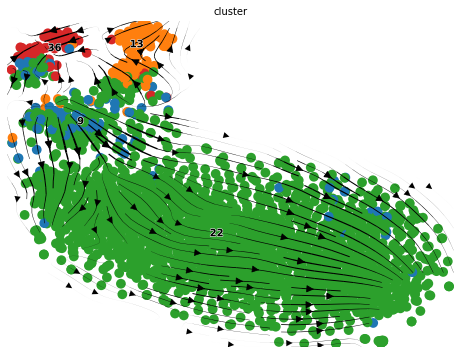

In [4]:
scv.pl.velocity_embedding_stream(adata_scv, basis='X_tsne',color="cluster",figsize=[8,6],s=380,alpha=1,density=1.5,arrow_size=1.5,smooth=1)

In [34]:
scv.tl.latent_time(adata_scv)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root cell 11 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root cell 460 as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


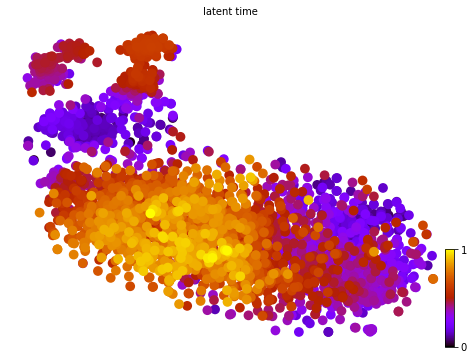

In [83]:
scv.pl.scatter(adata_scv, color='latent_time', color_map='gnuplot',figsize=[8,6],s=380,alpha=1,legend_loc='None')

## deepvelo

In [105]:
from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants
from deepvelo.utils.temporal import latent_time

In [106]:
adata_dv = ldata1.copy()

In [107]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata_dv)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)
configs['n_gpu']=0

The ratio of spliced reads is 90.9% (more than 85%). Suggest using coeff_s 1.0.


In [108]:
velocity(adata_dv, mask_zero=False)
trainer = train(adata_dv, configs)

building graph
velo data shape: torch.Size([2419, 2000])
velo_mat shape: (2419, 2000)


In [109]:
scv.tl.velocity_graph(adata_dv, n_jobs=8)

  0%|          | 0/2419 [00:00<?, ?cells/s]

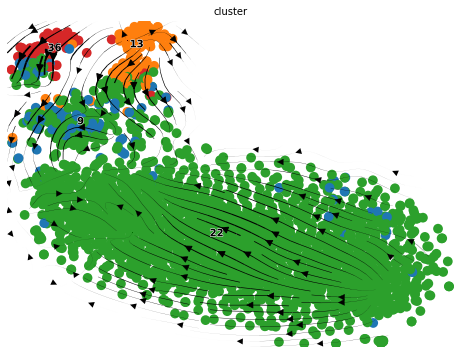

In [110]:
scv.pl.velocity_embedding_stream(adata_dv, basis='X_tsne',color="cluster",figsize=[8,6],s=380,alpha=1,density=1.5,arrow_size=1.5,smooth=1)

In [111]:
latent_time(adata_dv)

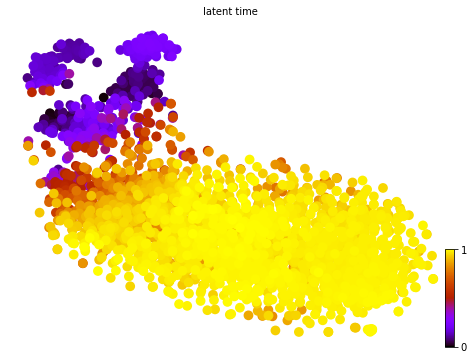

In [112]:
scv.pl.scatter(adata_dv, color='latent_time', color_map='gnuplot',figsize=[8,6],s=380,alpha=1,legend_loc='None')

## UnitVelo

In [92]:
import unitvelo as utv

(Running UniTVelo 0.2.4.3)
2022-10-30 12:31:32


In [93]:
adata_utv = ldata1.copy()

In [94]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'
velo_config.AGENES_R2 = 1

-------> Manully Specified Parameter <-------
None


-------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None


Current working dir is /home/wangkun
Results will be stored in res folder


2022-10-30 20:31:34.355777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/torque/lib
2022-10-30 20:31:34.355821: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-30 20:31:34.355847: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (node2): /proc/driver/nvidia/version does not exist
2022-10-30 20:31:34.356370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---> # of velocity genes used 177
---> # of velocity genes used 165
---> # of velocity genes used 165


173,106: 100%|███████████████████████████▉| 11999/12000 [51:50<00:00,  3.05it/s]

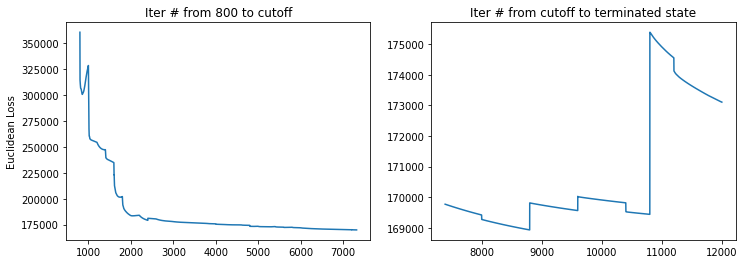

173,106: 100%|███████████████████████████▉| 11999/12000 [52:17<00:00,  3.82it/s]

Total loss 168931, vgene loss 173106


  0%|          | 0/2419 [00:00<?, ?cells/s]

In [95]:
adata = utv.run_model(adata_utv, 'cluster', config_file=velo_config)

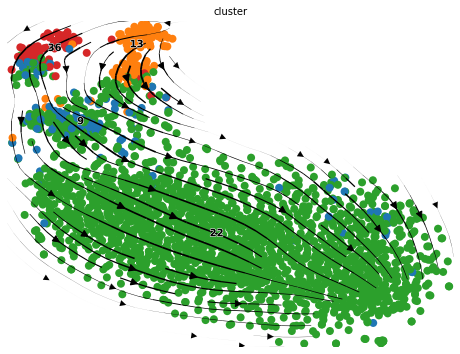

In [96]:
scv.pl.velocity_embedding_stream(adata_utv, color='cluster', basis='X_tsne',figsize=[8,6],s=255,alpha=1,density=1,arrow_size=1.5,smooth=1)

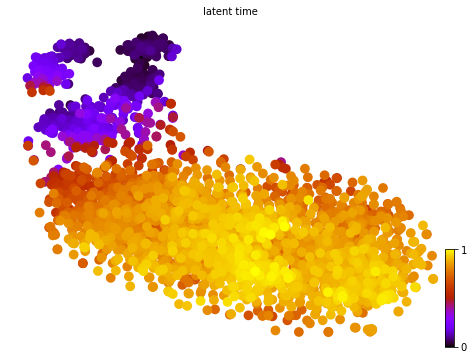

In [97]:
scv.tl.latent_time(adata_utv,min_likelihood=None)
scv.pl.scatter(adata_utv, color='latent_time', color_map='gnuplot',figsize=[8,6],s=380,alpha=1,legend_loc='None')

## VeloVAE

In [113]:
import sys
sys.path.append('/home/wangkun/VeloVAE-master/')
import velovae as vv

In [99]:
adata_vv = ldata1.copy()

In [100]:
torch.manual_seed(2022)
np.random.seed(2022)
full_vb = vv.VAEFullVB(adata_vv, tmax=20, dim_z=5)

Initialization using the steady-state and dynamical models.
Gaussian Prior.


In [101]:
full_vb.train(adata_vv, plot=True, figure_path='/home/wangkun/fullvb/erythroid', embed="tsne")

--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 14, test iteration: 26
Epoch 1: Train ELBO = -20283.090, Test ELBO = -955795.812, 	 Total Time =   0 h :  0 m :  1 s
Epoch 100: Train ELBO = 2218.711, Test ELBO = 2170.949, 	 Total Time =   0 h :  1 m : 28 s
Epoch 200: Train ELBO = 2405.235, Test ELBO = 2346.155, 	 Total Time =   0 h :  2 m : 56 s
Epoch 300: Train ELBO = 2517.227, Test ELBO = 2461.396, 	 Total Time =   0 h :  4 m : 23 s
Epoch 400: Train ELBO = 2655.491, Test ELBO = 2592.149, 	 Total Time

In [102]:
full_vb.save_anndata(adata_vv, 'fullvb',file_path='/home/wangkun/VeloVAE-master/', file_name="erythroid_out.h5ad")

  0%|          | 0/2419 [00:00<?, ?cells/s]

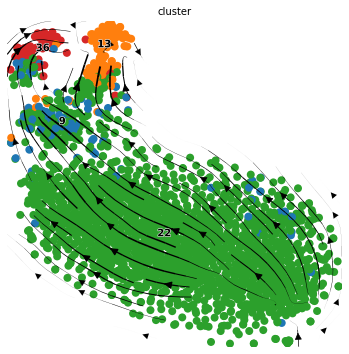

In [103]:
key = 'fullvb'
scv.tl.velocity_graph(adata_vv, vkey=f'{key}_velocity')
scv.tl.velocity_embedding(adata_vv, vkey=f'{key}_velocity')
scv.pl.velocity_embedding_stream(adata_vv, vkey=f'{key}_velocity', color='cluster', basis='X_tsne',figsize=[6,6],s=255,alpha=1,density=1,arrow_size=1.5,smooth=1)

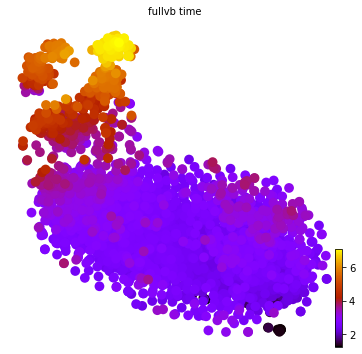

In [104]:
scv.pl.scatter(adata_vv, color='fullvb_time', color_map='gnuplot',figsize=[6,6],s=380,alpha=1,legend_loc='None')

In [85]:
import phylovelo as pv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def norm_time(x):
    x -= min(x)
    return x/max(x)

In [86]:
cmap = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_map = dict(zip([9,36,13,22], [0, 3, 1, 2]))
state_map = dict(zip([9,36,13,22,32], ['primitive blood early', 'primitive blood progenitors', 'hematopoietic/endothelial progenitors', 'primitive blood late', 'angioblasts']))

In [88]:
adata = ldata1

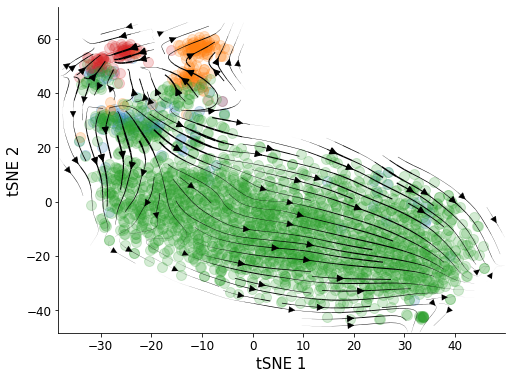

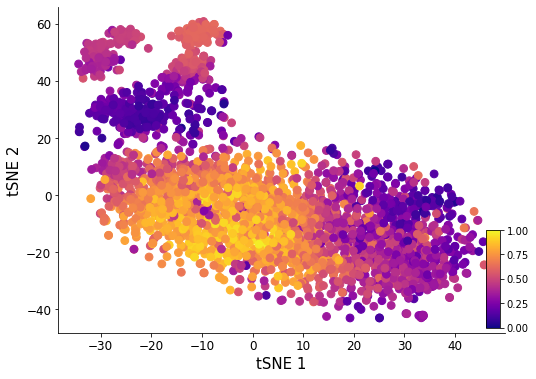

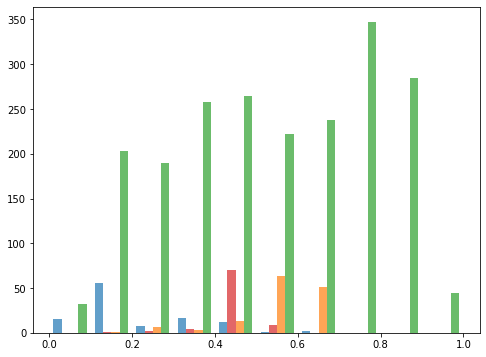

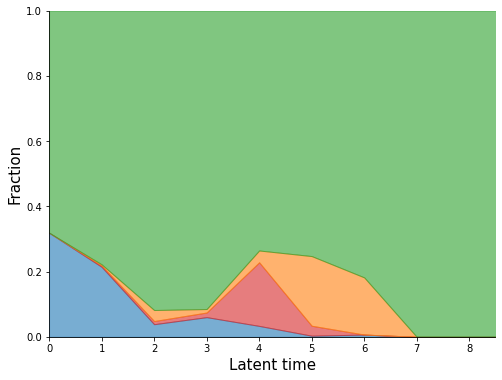

In [91]:
name = 'erythroid_scvelo'
fig, ax = plt.subplots()
for i in set(adata.obs['cluster']):
    ax.scatter(adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 0], adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 1], c=cmap[color_map[int(i)]], s=100, alpha=0.2, label=state_map[int(i)])
ax = pv.ana_utils.velocity_plot(adata.obsm['X_tsne'], adata_scv.obsm['velocity_tsne'], ax, 'stream',streamdensity=1.5, radius=5, lw_coef=2, arrowsize=1.5)
ax.figure.set_size_inches(8,6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')

fig, ax = plt.subplots()
scatter = ax.scatter(adata.obsm['X_tsne'][:, 0], adata.obsm['X_tsne'][:, 1], c=adata_scv.obs['latent_time'], cmap='plasma', s=60)
ax.figure.set_size_inches(8,6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')

phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = adata_scv.obs.latent_time.to_numpy()[np.where(np.array(adata_scv.obs['cluster'])==str(i))]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(adata.obs['cluster']):
    hist_data.append(phytime_bar[state_map[int(i)]])
    hist_labels.append(state_map[int(i)])
    hist_colors.append(cmap[color_map[int(i)]])
    
fig, ax = plt.subplots(figsize=(8,6))
hd = ax.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))

pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Latent time', fontsize=15)

ax.set_ylabel('Fraction', fontsize=15)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_muller.png', format='png')

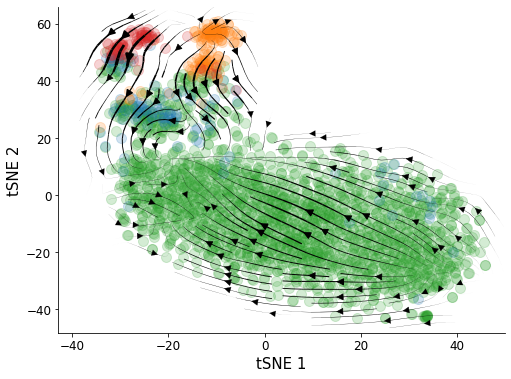

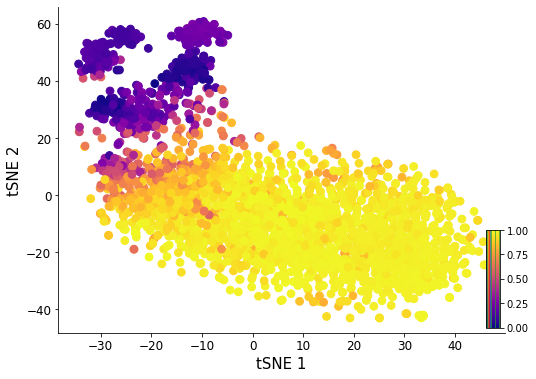

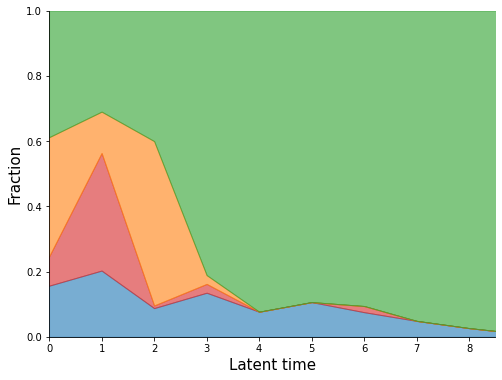

In [120]:
name = 'erythroid_deepvelo'

fig, ax = plt.subplots()
for i in set(adata.obs['cluster']):
    ax.scatter(adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 0], adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 1], c=cmap[color_map[int(i)]], s=100, alpha=0.2, label=state_map[int(i)])
ax = pv.ana_utils.velocity_plot(adata.obsm['X_tsne'], adata_dv.obsm['velocity_tsne'], ax, 'stream',streamdensity=1.5, radius=5, lw_coef=2, arrowsize=1.5)
ax.figure.set_size_inches(8,6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')

fig, ax = plt.subplots()
scatter = ax.scatter(adata.obsm['X_tsne'][:, 0], adata.obsm['X_tsne'][:, 1], c=adata_dv.obs['latent_time'], cmap='plasma', s=60)
ax.figure.set_size_inches(8,6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')

phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = adata_dv.obs.latent_time.to_numpy()[np.where(np.array(adata.obs['cluster'])==str(i))]
hist_data = []
hist_labels = []
hist_colors = []
for i in '9,36,13,22'.split(','):
    hist_data.append(phytime_bar[state_map[int(i)]])
    hist_labels.append(state_map[int(i)])
    hist_colors.append(cmap[color_map[int(i)]])
    
hd = plt.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))

pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Latent time', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_muller.png', format='png')

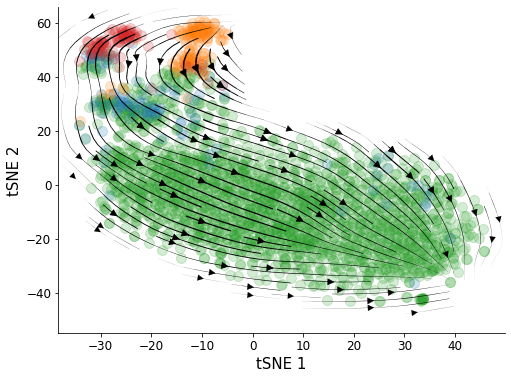

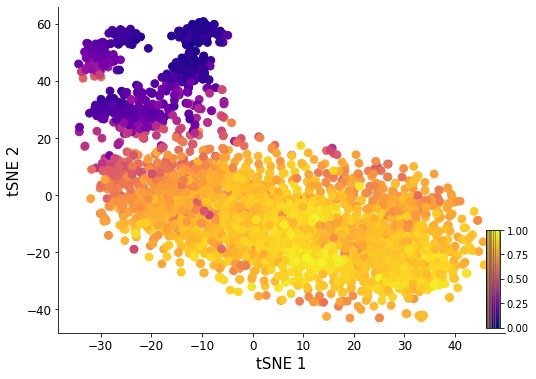

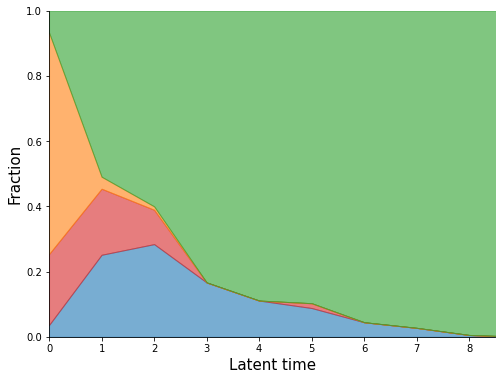

In [119]:
name = 'erythroid_unitvelo'

fig, ax = plt.subplots()
for i in set(adata.obs['cluster']):
    ax.scatter(adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 0], adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 1], c=cmap[color_map[int(i)]], s=100, alpha=0.2, label=state_map[int(i)])
ax = pv.ana_utils.velocity_plot(adata.obsm['X_tsne'], adata_utv.obsm['velocity_tsne'], ax, 'stream',streamdensity=1.5, radius=5, lw_coef=2, arrowsize=1.5)
ax.figure.set_size_inches(8,6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')

fig, ax = plt.subplots()
scatter = ax.scatter(adata.obsm['X_tsne'][:, 0], adata.obsm['X_tsne'][:, 1], c=adata_utv.obs['latent_time'], cmap='plasma', s=60)
ax.figure.set_size_inches(8,6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')
phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = adata_utv.obs.latent_time.to_numpy()[np.where(np.array(adata.obs['cluster'])==str(i))]
hist_data = []
hist_labels = []
hist_colors = []
for i in '9,36,13,22'.split(','):
    hist_data.append(phytime_bar[state_map[int(i)]])
    hist_labels.append(state_map[int(i)])
    hist_colors.append(cmap[color_map[int(i)]])
    
hd = plt.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))

pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Latent time', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_muller.png', format='png')

Text(0, 0.5, 'Fraction')

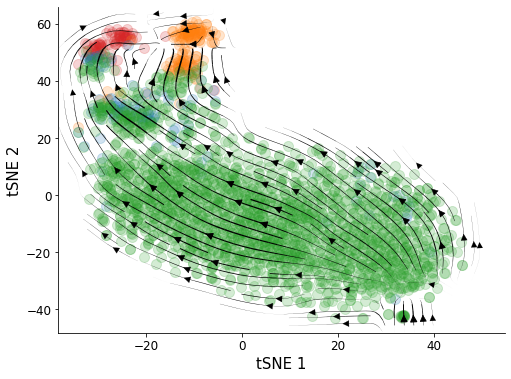

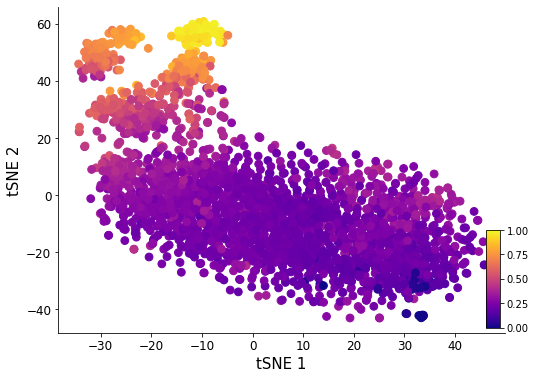

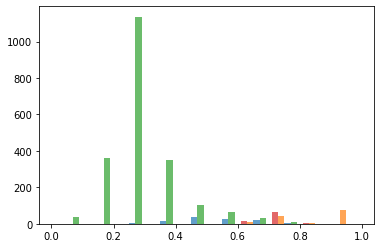

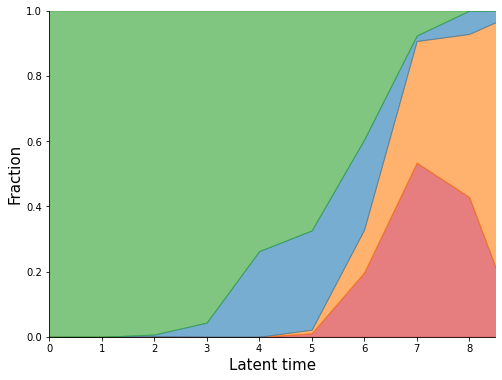

In [74]:
name = 'erythroid_velovae'

fig, ax = plt.subplots()
for i in set(adata.obs['cluster']):
    ax.scatter(adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 0], adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 1], c=cmap[color_map[int(i)]], s=100, alpha=0.2, label=state_map[int(i)])
ax = pv.ana_utils.velocity_plot(adata.obsm['X_tsne'], adata_vv.obsm['fullvb_velocity_tsne'], ax, 'stream',streamdensity=1.5, radius=5, lw_coef=2, arrowsize=1.5)
ax.figure.set_size_inches(8,6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'.png', format='png')

fig, ax = plt.subplots()
scatter = ax.scatter(adata.obsm['X_tsne'][:, 0], adata.obsm['X_tsne'][:, 1], c=norm_time(adata_vv.obs['fullvb_time']), cmap='plasma', s=60)
ax.figure.set_size_inches(8,6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_lt.png', format='png')

phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = norm_time(adata_vv.obs['fullvb_time'].to_numpy())[np.where(np.array(adata.obs['cluster'])==str(i))]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(adata.obs['cluster']):
    hist_data.append(phytime_bar[state_map[int(i)]])
    hist_labels.append(state_map[int(i)])
    hist_colors.append(cmap[color_map[int(i)]])
fig, ax = plt.subplots()
hd = ax.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))

pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Latent time', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
plt.savefig('/home/wangkun/modelcomp_figs/'+name+'_muller.png', format='png')

In [ ]:
import celldancer.utilities as cdutil
cdutil.adata_to_df_with_embed(ldata2,
                              us_para=['Mu','Ms'],
                              cell_type_para='cluster',
                              embed_para='X_tsne',
                              save_path='cell_type_u_s.csv')

In [23]:
cell_type_u_s=pd.read_csv('./cell_type_u_s.csv')

In [ ]:
loss_df, cellDancer_df=cd.velocity(cell_type_u_s,\
                                   permutation_ratio=0.125,\
                                   n_jobs=10)

In [25]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=10, speed_up=(100,100))

In [30]:
from celldancer.utilities import export_velocity_to_dynamo

In [32]:
adata = export_velocity_to_dynamo(cellDancer_df,ldata2)

In [34]:
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [39]:
dt = 0.001
t_total = {dt: 10000}
n_repeats = 10
# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                                          grid=(30, 30),
                                          dt=dt,
                                          t_total=t_total[dt],
                                          n_repeats=n_repeats,
                                          speed_up=(60,60),
                                          n_paths = 5,
                                          psrng_seeds_diffusion=[i for i in range(n_repeats)],
                                          n_jobs=8)

Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|████████████| 15960/15960 [04:01<00:00, 66.03it/s]


There are 5 clusters.
[0 1 2 3 4]
There are cycle(s), forcing a break.
--- 595.2359387874603 seconds ---


In [40]:
pseudotime = cellDancer_df[['cellID', 'pseudotime']].drop_duplicates('cellID')
pseudotime.index = pseudotime['cellID']

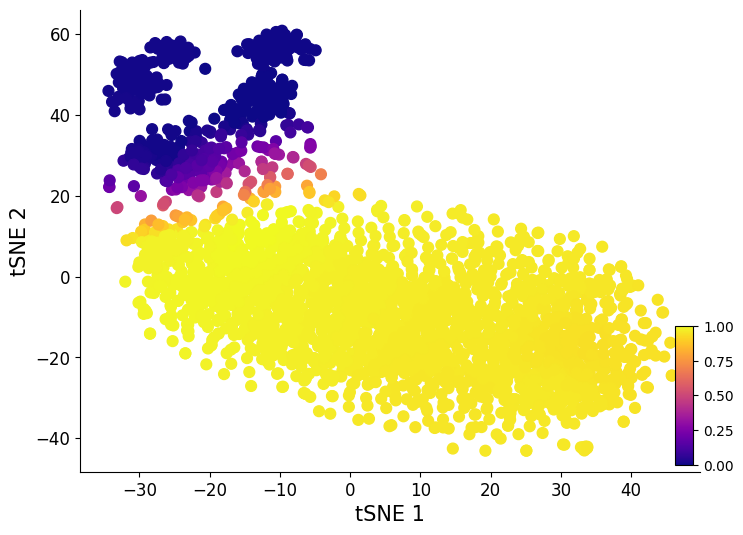

In [43]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots()
scatter = ax.scatter(adata.obsm['X_tsne'][:, 0], adata.obsm['X_tsne'][:, 1], c=1-pseudotime.loc[adata.obs_names]['pseudotime'], cmap='plasma', s=60)
ax.figure.set_size_inches(8,6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Text(0, 0.5, 'Fraction')

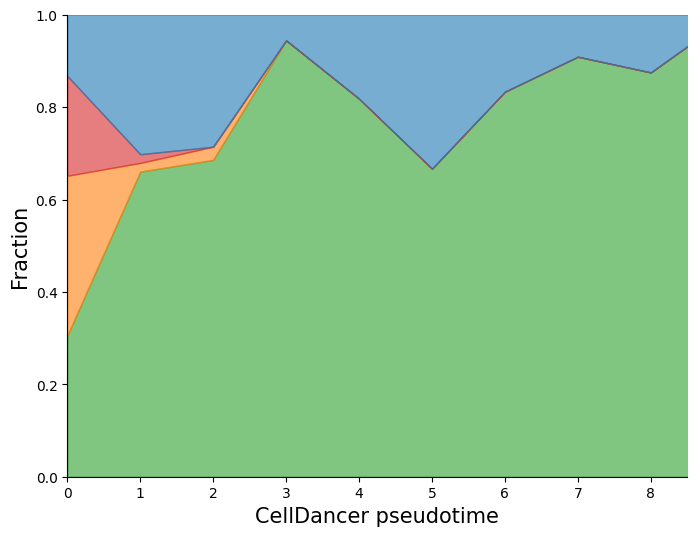

In [55]:
phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = np.array(1-pseudotime.loc[adata.obs_names]['pseudotime'])[np.where(np.array(adata.obs['cluster'])==str(i))]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(adata.obs['cluster']):
    hist_data.append(phytime_bar[state_map[int(i)]])
    hist_labels.append(state_map[int(i)])
    hist_colors.append(cmap[color_map[int(i)]])

fig, ax = plt.subplots(figsize=(8,6))

pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('CellDancer pseudotime', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)

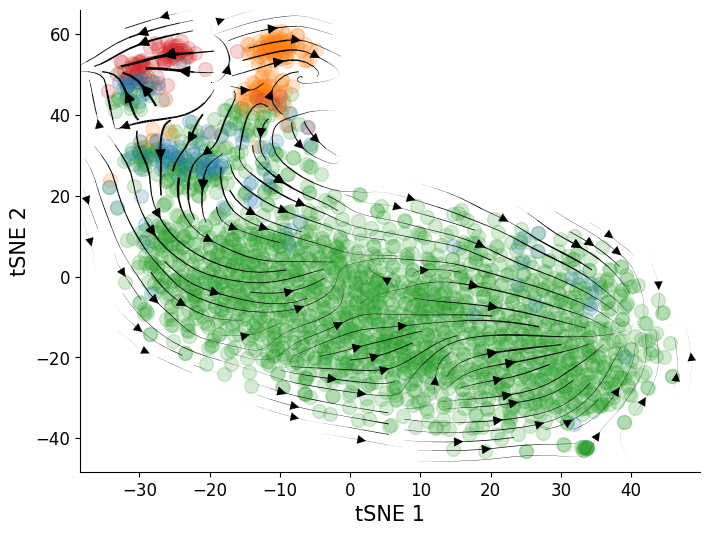

In [54]:
fig, ax = plt.subplots()
for i in set(adata.obs['cluster']):
    ax.scatter(adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 0], adata.obsm['X_tsne'][np.array(adata.obs['cluster'])==i, 1], c=cmap[color_map[int(i)]], s=100, alpha=0.2, label=state_map[int(i)])
ax = pv.ana_utils.velocity_plot(adata.obsm['X_tsne'], adata.obsm['velocity_tsne'], ax, 'stream',streamdensity=1.5, radius=5, lw_coef=2, arrowsize=1.5)
ax.figure.set_size_inches(8,6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)